In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd
import uproot as ur
import statistics
import k3d
import numpy as np
import awkward as ak
import matplotlib.colors as mcolors
from scipy.stats import norm
import mplhep as hep
import hist
from hist import Hist
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["legend.fontsize"] = 16

### User Defined

In [2]:
#Open root file for sim beam data
input_file = 'reco_e+_4GeV.root'
events = ur.open("%s:events"%(input_file))
arrays = events.arrays()
hitenergy = arrays['hit_energy']
layers = arrays['hit_cellID']
#xpos = arrays['HCALHitsReco.position.x']
#ypos = arrays['HCALHitsReco.position.y']
#zpos = arrays['HCALHitsReco.position.z']


#random trigger data
ptrigDF = pd.read_pickle(r'./PTRIG_LG50_HG50_4k_R28.pkl')
#beam data
df = pd.read_pickle(r'./BEAM_LG50_HG50_4k_R27.pkl')
#cosmic data
cosmic_df = pd.read_pickle(r'./COSMIC_LG50_HG50_4k_R2.pkl')

#set to 1 for 4k files, 2 for 8k files
ADCmult = 1

#All hits below this threshold are set to zero
MIPCut = 0.3

#Apply MIP scaling and pedestal ADC value here for simulation

#ADCs per MIP for simulation, set to 1 if the file is in units of MIPs
ADCtoMIP = 1

#Pedestal value for simulation, in whatever units the file is in
SimPedestal = 0

simPedMeans = np.full(40, SimPedestal)
simMips = np.full(40, ADCtoMIP)

In [3]:
print(cosmic_df)

       Ch_00_LG  Ch_00_HG  Ch_01_LG  Ch_01_HG  Ch_02_LG  Ch_02_HG  Ch_03_LG  \
0         104.0     444.0      67.0     104.0      69.0      85.0      72.0   
1          68.0      63.0      66.0      59.0      72.0      57.0      62.0   
2          72.0      63.0      66.0      62.0      67.0      60.0      66.0   
3         245.0    1792.0      69.0      69.0      67.0      67.0      78.0   
4         117.0     548.0      64.0      59.0      75.0      67.0      67.0   
...         ...       ...       ...       ...       ...       ...       ...   
55834      63.0      51.0      57.0      73.0      54.0      50.0      59.0   
55835      68.0      71.0     145.0     875.0      68.0      65.0      58.0   
55836      65.0      68.0      62.0      60.0      68.0      66.0      63.0   
55837      63.0      67.0      58.0      69.0     112.0     519.0      57.0   
55838      64.0      58.0     107.0     459.0      60.0      74.0      60.0   

       Ch_03_HG  Ch_04_LG  Ch_04_HG  ...  Ch_35_HG 

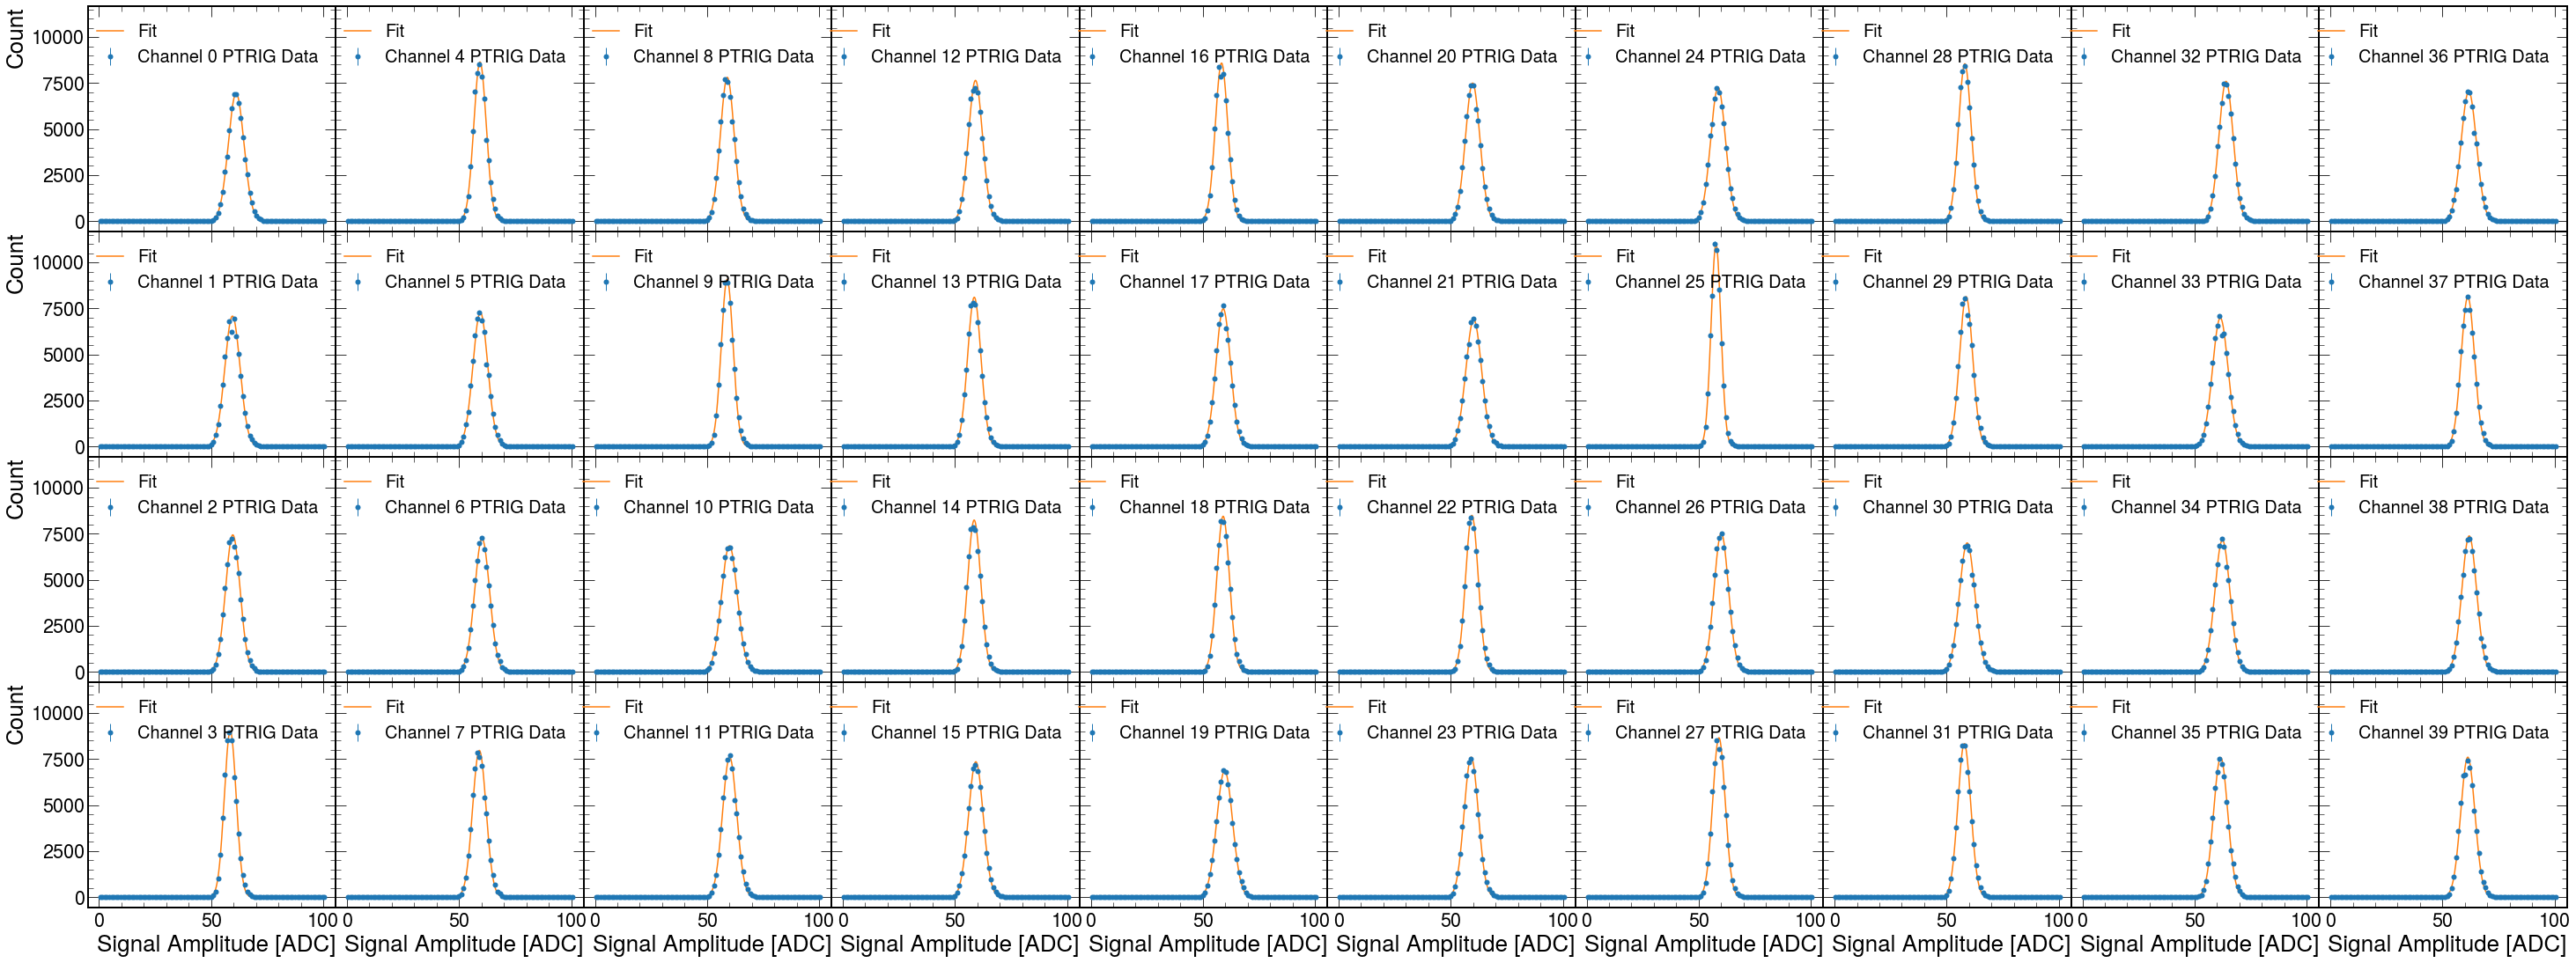

In [4]:
#plot random trigger spectra for each low gain channel. Fit to gaussian and record pedestals for cuts later

fig, axs=plt.subplots(4, 10, figsize=(0.5*len(df.columns),15),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

pedMeans = []
pedStds = []

for i in range(round(len(df.columns)/2)):
    plt.sca(axs[i%4][i//4])
    
    h = hist.Hist(hist.axis.Regular(100, 0, 101, name="Ptrig"))
    h.fill(np.array(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))))
    #h.plot(color='blue',label=f"Channel {i} PTRIG Data")  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} PTRIG Data")

    # Initial parameter values for the fit
    #initial_params = [max(h), sum(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i))))/len(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))), 2.5]
    initial_params = [10000,60,2.5]
    # Create Minuit object and set up the fit
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = y>0
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    m = Minuit(LeastSquares(x, y, yerr, gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']

    
    x = np.linspace(0, 100, 1000)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper right', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 3:
        plt.ylabel('Count')
  
    #plt.yscale("log") 
    
    pedMeans.append(mu_fit)
    pedStds.append(sigma_fit)
    
# Adjust the spacing between subplots
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

Average mean value:
59.75048891126471
Average width value:
3.1136442907127324
[61.11278484631194, 59.46352589521336, 59.625384105110726, 58.49427242680736, 59.310336152895324, 59.454089180073986, 60.23927907337853, 59.01295380073833, 59.03288991964495, 58.96744566046286, 59.96230807576774, 60.076034945601556, 59.15045795039773, 58.609099671846735, 58.5629499602307, 59.3047250457339, 58.32487266983219, 59.07913080601146, 59.03080087844011, 59.70406139870801, 59.73617963381234, 60.21405423753652, 59.41666546099419, 59.09412857694322, 58.63271662116127, 57.70460540214853, 60.057884455159666, 59.01310990000603, 58.11897105479453, 58.67853395233365, 59.15418192456056, 57.87693108928134, 64.03981562425592, 61.48243723436236, 62.410270391044946, 61.64064245162681, 61.71276950375749, 61.30401528062744, 61.91398761634609, 61.30025357662782]
[3.4842178371213057, 3.401196945897126, 3.237669598421193, 2.6511336698723933, 2.766357459735262, 3.3063737588392996, 3.34501395468076, 3.0099929030822374, 

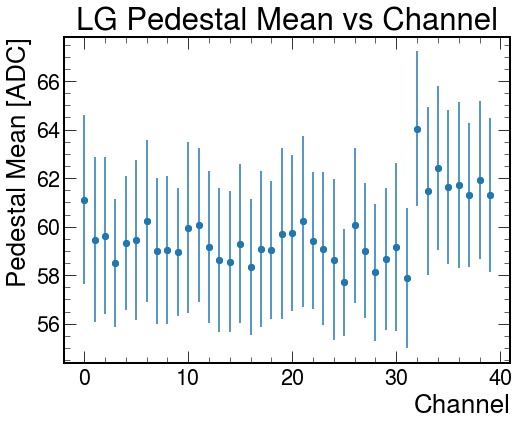

In [5]:
#plot pedestals means and stds for low gain

fig = plt.figure( figsize=(8, 6))
plt.scatter(range(0,40),pedMeans)
plt.xlabel('Channel')
plt.ylabel('Pedestal Mean [ADC]')
plt.title("LG Pedestal Mean vs Channel")
plt.errorbar(range(0,40), pedMeans, yerr=pedStds, fmt="o")
print("Average mean value:")
print(np.mean(pedMeans))
print("Average width value:")
print(np.mean(pedStds))
print(pedMeans)
print(pedStds)

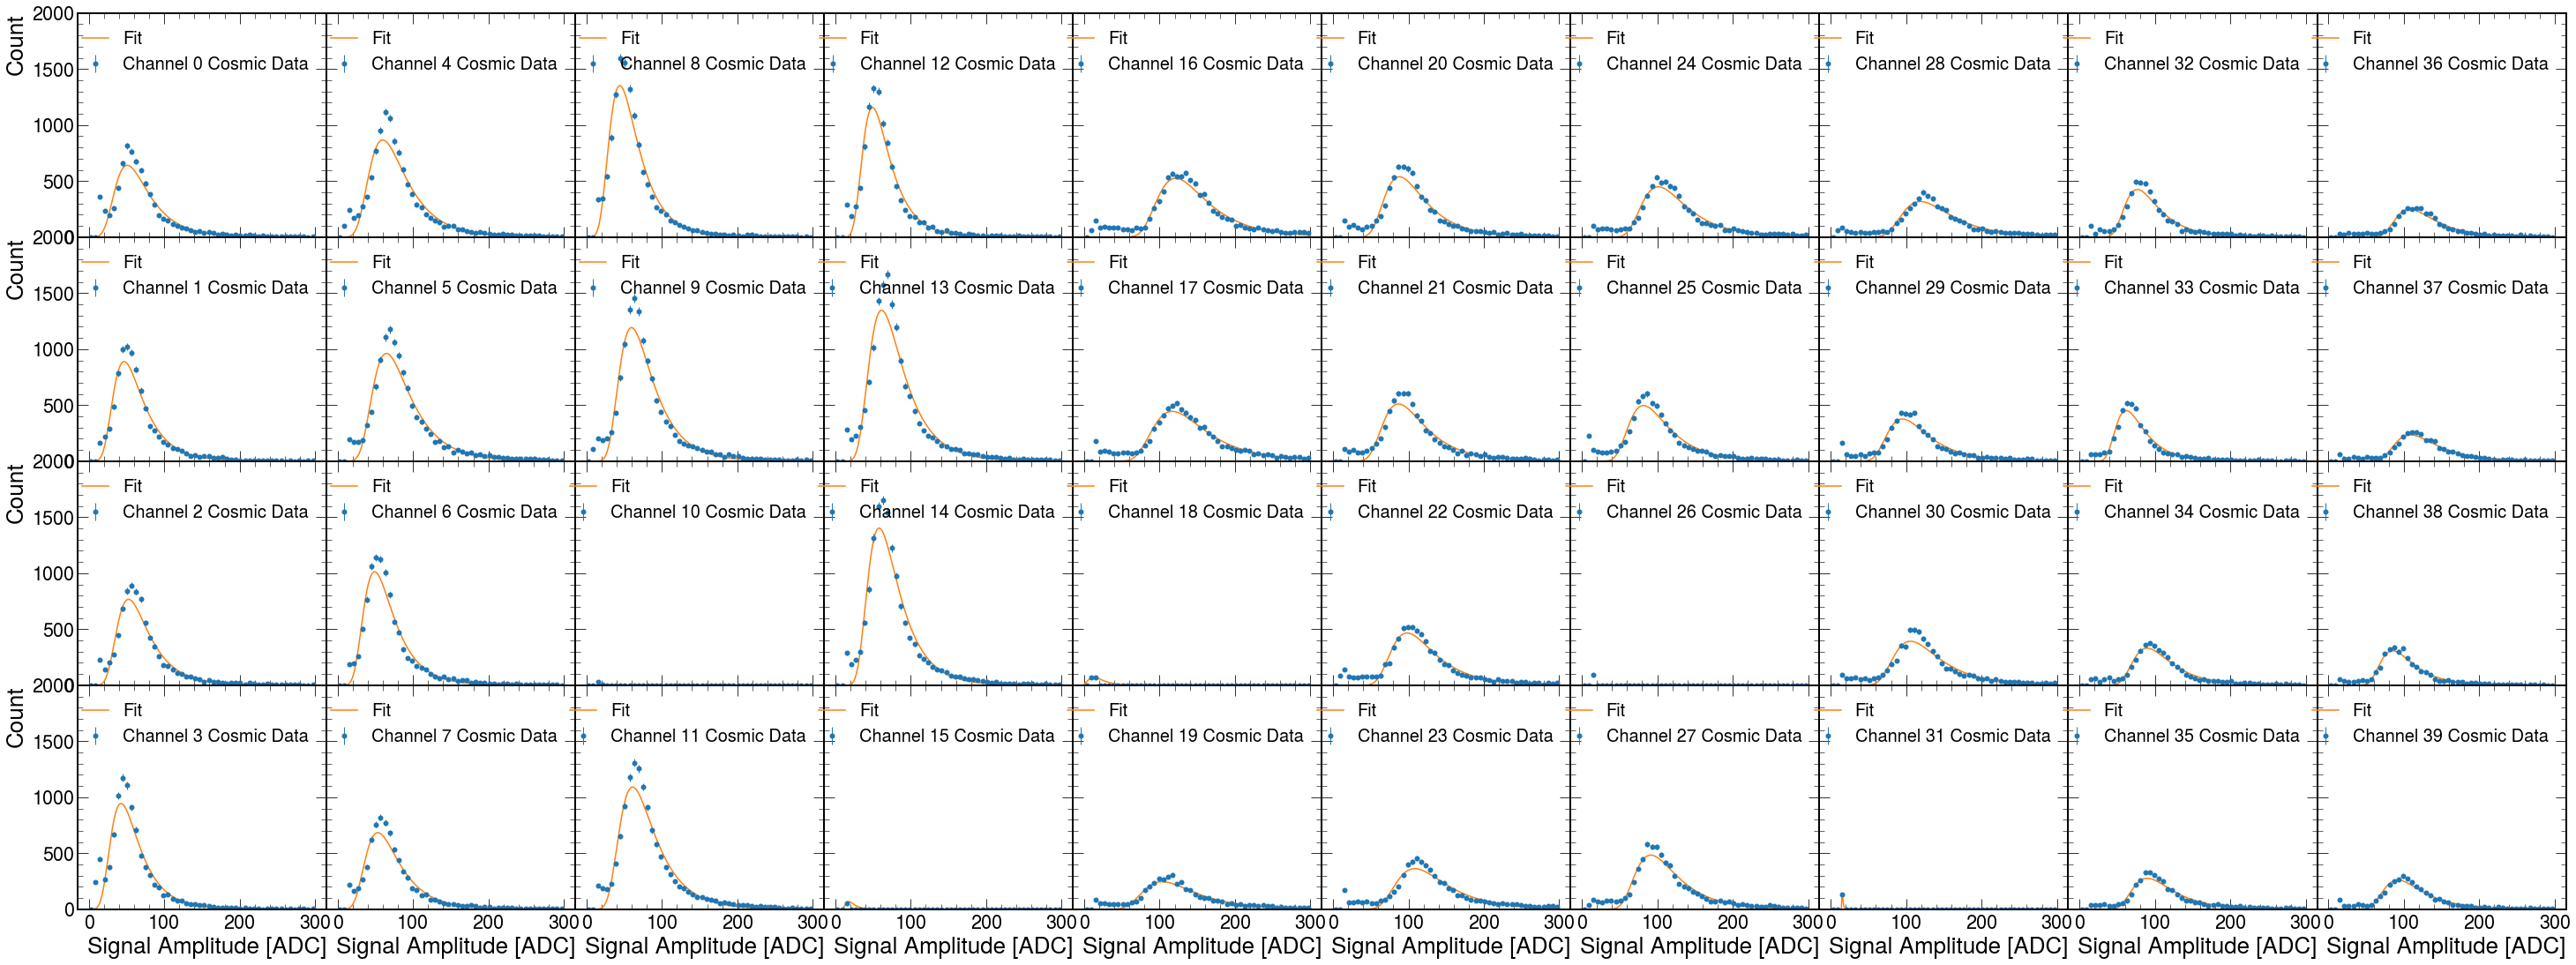

In [6]:
#plot random trigger spectra for each low gain channel. Fit to gaussian and record pedestals for cuts later

fig, axs=plt.subplots(4, 10, figsize=(0.5*len(df.columns),15),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def landau(x, A, mu, sigma):
    u = (x - mu)*3.591/(sigma/2.355)
    Aprime = 1.648*A
    return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

def least_squares_landau(A, mu, sigma):
    y = landau(bins, A, mu, sigma)
    return np.sum((data - y)**2)

mips = []
mipStds = []

for i in range(round(len(df.columns)/2)):
    plt.sca(axs[i%4][i//4])

    h = hist.Hist(hist.axis.Regular(50, 0, 300, name="Ptrig"))
    
    cosmicCh = np.array(getattr(cosmic_df,"Ch_{}_LG".format("{:02d}".format(i))))
    cosmicCh = cosmicCh[cosmicCh >= (pedStds[i] * 4)+pedMeans[i]] - pedMeans[i]

    h.fill(cosmicCh)
  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} Cosmic Data")

    
    # Find the bin number with the maximum value
    max_bin_number = np.argmax(h.values())

    # Get the axis from the histogram
    axis = h.axes[0]

    # Find the x-coordinate corresponding to the maximum bin
    x_coordinate = axis.edges[max_bin_number]
    #mips.append(x_coordinate)
    
    # Initial parameter values for the fit
    initial_params = [max(h), np.mean(cosmicCh), np.std(cosmicCh)]
    # Create Minuit object and set up the fit
    x = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    y = h.values()[()]
    yerr = np.sqrt(y)
    mask = y>0
    x = x[mask]
    yerr = yerr[mask]
    y = y[mask]
    cost = LeastSquares(x, y, yerr, landau)
    m = Minuit(cost, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    m.limits["mu"] = (0, 200)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    
    x = np.linspace(0, 300, 1000)
    y_fit = landau(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper right', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 3:
        plt.ylabel('Count')
    
    mips.append(mu_fit)
    mipStds.append(sigma_fit)
    
# Adjust the spacing between subplots
plt.ylim(0,2000)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

Average mean value:
79.4980659162876
Average width value:
265.3821658718368


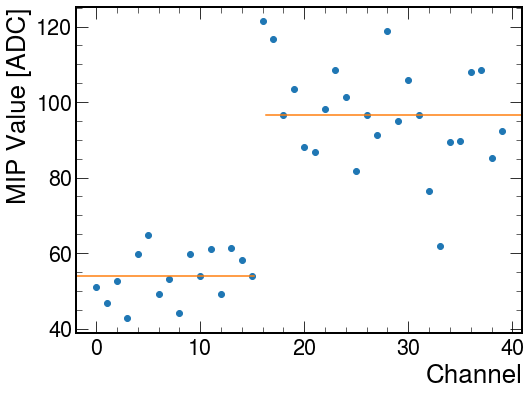

In [7]:
mips = np.array(mips)

# Section 1
section1 = mips[0:16]
excluded_indexes1 = [10, 15]
mask1 = np.ones_like(section1, dtype=bool)
mask1[excluded_indexes1] = False
mips[10] = np.mean(section1[mask1])
mips[15] = np.mean(section1[mask1])

# Section 2
section2 = mips[16:40]
excluded_indexes2 = [18-16, 26-16, 31-16]
mask2 = np.ones_like(section2, dtype=bool)
mask2[excluded_indexes2] = False
mips[18] = np.mean(section2[mask2])
mips[26] = np.mean(section2[mask2])
mips[31] = np.mean(section2[mask2])


fig = plt.figure( figsize=(8, 6))
plt.scatter(range(0,40),mips)
plt.xlabel('Channel')
plt.ylabel('MIP Value [ADC]')

plt.axhline(y = np.mean(section1[mask1]), color = 'tab:orange', xmax = 16/40)
plt.axhline(y = np.mean(section2[mask2]), color = 'tab:orange', xmin = 17/40)

print("Average mean value:")
print(np.mean(mips))
print("Average width value:")
print(np.mean(mipStds))

In [8]:
def calibrate_dataframe(df, mips, pedMeans):
    # Create a new numpy array with the same shape as the dataframe
    new_array = np.zeros_like(df.values)

    # Iterate over the columns of the dataframe
    for col_idx, col_name in enumerate(df.columns):
        # Check if the column represents an LG value
        if col_name.endswith('_LG'):
            # Get the corresponding channel index
            ch = col_name.split('_')[1]

            # Calculate the new values using the formula
            new_values = (df[col_name].values - pedMeans[int(ch)]) / mips[int(ch)]

            # Set values less than the MIPCut to 0
            new_values[new_values < MIPCut] = 0

            # Store the updated values in the corresponding column of new_array
            new_array[:, col_idx] = new_values

    # Create a new dataframe from the new numpy array with only LG columns
    lg_columns = [col for col in df.columns if col.endswith('_LG')]
    calibrated_df = pd.DataFrame(new_array[:, df.columns.isin(lg_columns)], columns=lg_columns, index=df.index)
    
    
    # Set dead channel values to 0
    calibrated_df['Ch_01_LG'] = 0.0
    calibrated_df['Ch_07_LG'] = 0.0
    
    # Count the number of nonzero values in each row
    #num_nonzero_values = calibrated_df.iloc[:, 0:41].astype(bool).sum(axis=1)
    num_nonzero_values = new_array.astype(bool).sum(axis=1)

    #Like in the data, require at least 4 hits in each event
    calibrated_df = calibrated_df[num_nonzero_values > 3]
    
    return calibrated_df

def only_lowgain(df):
    # Create a new numpy array with the same shape as the dataframe
    new_array = np.zeros_like(df.values)

    # Iterate over the columns of the dataframe
    for col_idx, col_name in enumerate(df.columns):
        # Check if the column represents an LG value
        if col_name.endswith('_LG'):
            # Get the corresponding channel index
            ch = col_name.split('_')[1]

            # Calculate the new values using the formula
            new_values = df[col_name].values

            # Store the updated values in the corresponding column of new_array
            new_array[:, col_idx] = new_values

    # Create a new dataframe from the new numpy array with only LG columns
    lg_columns = [col for col in df.columns if col.endswith('_LG')]
    onlyLG_df = pd.DataFrame(new_array[:, df.columns.isin(lg_columns)], columns=lg_columns, index=df.index)
    
    return onlyLG_df

def calculate_channel_sums(df, channel_numbers):
    # Get the values corresponding to the channel numbers as a NumPy array
    selected_values = df.iloc[:, channel_numbers].values

    # Calculate the sum along the channel axis
    channel_sums = np.sum(selected_values, axis=1)

    return channel_sums

def get_max_values(df):
    max_values = []
       # Create a new numpy array with the same shape as the dataframe

    # Iterate over the columns of the dataframe
    for col_idx, col_name in enumerate(df.columns):
        # Check if the column represents an LG value
        if col_name.endswith('_LG'):
            # Get the corresponding channel index
            ch = col_name.split('_')[1]

            # Find maximum value for each channel
            max_values.append(np.max(df[col_name].values))
    return max_values

def max_out(df, max_values):
# Create a new numpy array with the same shape as the dataframe
    new_array = np.zeros_like(df.values)

    # Iterate over the columns of the dataframe
    for col_idx, col_name in enumerate(df.columns):
        # Check if the column represents an LG value
        if col_name.endswith('_LG'):
            # Get the corresponding channel index
            ch = col_name.split('_')[1]

            # Calculate the new values using the formula
            new_values = df[col_name].values
            
            # Set values larger than max value to the max value
            new_values[new_values > max_values[col_idx]] = max_values[col_idx]

            # Store the updated values in the corresponding column of new_array
            new_array[:, col_idx] = new_values

    # Create a new dataframe from the new numpy array with only LG columns
    lg_columns = [col for col in df.columns if col.endswith('_LG')]
    maxed_df = pd.DataFrame(new_array[:, df.columns.isin(lg_columns)], columns=lg_columns, index=df.index)
    
    return maxed_df
    

def get_layer_positions(in_df, option):
    # Define the channel positions for each layer
    channel_positions = np.array([[-4.74/2, 4.74/2], [4.74/2, 4.74/2], [-4.74/2, -4.74/2], [4.74/2, -4.74/2]])
    
    # Get the number of events and layers
    num_events = len(in_df)
    num_layers = 10
    
    # Extract the layer channels from the DataFrame
    layer_channels = np.array(in_df.iloc[:, :40]).reshape(num_events, num_layers, 4)
    
    # Calculate the total energy for each layer
    total_energy = np.sum(layer_channels, axis=2)
    
    # Calculate the energy-weighted positions for each layer
    weighted_positions = np.sum(layer_channels[:, :, :, np.newaxis] * channel_positions, axis=2) / total_energy[:, :, np.newaxis]
    
    # Create a new DataFrame with the energy-weighted positions
    positions_df = pd.DataFrame({'X_Positions': weighted_positions[:, :, 0].tolist(), 'Y_Positions': weighted_positions[:, :, 1].tolist()})
    
    # Initialize a 2D list to store the layer positions
    layer_positions = [[] for _ in range(num_layers)]
    
    # Determine which option to use ('x' or 'y')
    if option == 'x':
        positions_column = 'X_Positions'
    elif option == 'y':
        positions_column = 'Y_Positions'
    else:
        raise ValueError("Invalid option. Please choose 'x' or 'y'.")
    
    # Iterate over the rows in the positions column
    for row in positions_df[positions_column]:
        # Iterate over the layers and append the corresponding position to the layer list
        for layer_idx, position in enumerate(row):
            layer_positions[layer_idx].append(position)
    
    return np.array(layer_positions)

def assign_layer_numbers(arr):
    # Flatten the input jagged array and turn it into a set to find unique position values
    unique_positions = sorted(set(ak.flatten(arr)))

    # Create a copy of the original array
    arr_copy = ak.copy(arr)

    # Create a loop from 0 to 9 to replace the position values with layer numbers
    for layer_number, position_value in enumerate(unique_positions):
        arr_copy = ak.where(arr_copy == position_value, layer_number, arr_copy)

    return arr_copy

def get_cell_values(hitenergy, mask):
    cell_values = ak.Array(np.zeros(len(hitenergy)))

    # Use the mask to extract hitenergy values for the desired cell
    cell_values = np.where(mask, hitenergy, 0)

    # Take the maximum value along the second axis to get the first non-zero value
    cell_values = np.max(cell_values, axis=1)

    return cell_values

def create_boolean_mask(chnum, layers, xpos, ypos):
    mask = np.zeros_like(layers, dtype=bool)

    if chnum % 4 == 0:
        mask = (layers == chnum // 4) & (xpos > 0) & (ypos > 0)
    elif chnum % 4 == 1:
        mask = (layers == chnum // 4) & (xpos < 0) & (ypos > 0)
    elif chnum % 4 == 2:
        mask = (layers == chnum // 4) & (xpos > 0) & (ypos < 0)
    elif chnum % 4 == 3:
        mask = (layers == chnum // 4) & (xpos < 0) & (ypos < 0)

    return mask

In [9]:
#Create a calibrated dataframe with test beam data, applying pedestal shifts, MIP scaling, and a MIP cut

#mips = [52.74750277855359, 48.30860848773839, 53.943404039851835, 44.92190677955567, 61.26714324627709, 65.86727404494636,
#50.49966238440961, 55.02522837553596, 46.61446015527332, 60.39973772203866, 55.30173491280392, 62.707398178412745,
#50.482420120919734, 62.40987646935536, 59.02966599638661, 55.30173491280392, 123.13587491197416, 118.85827154485337,
#93.36027551977364, 104.55347745998186, 88.72268957494947, 87.9317698337502, 99.4048611423608, 109.98290193288523,
#102.39942115610283, 82.29288341793296, 93.36027551977364, 93.1310966604848, 120.5428145522235, 96.02936108638767,
#107.29564320373284, 93.36027551977364, 78.16073077714876, 62.53205599751284, 90.81216227164441, 90.71800272849238,
#109.00527397085415, 109.68782873235487, 85.36866495961932, 93.52544458950403]
mips = [i * ADCmult for i in mips]
print(np.mean(mips))
print(len(df))

data_df = calibrate_dataframe(df, mips, pedMeans)
print(len(data_df))
beamEvts = len(data_df)
max_values = get_max_values(data_df)

79.4980659162876
619699
618685


In [10]:
# Create an empty dictionary to store column names and values
data = {}

#layers = assign_layer_numbers(zpos)

# Iterate over the range of column numbers
for ch in range(40):
    print(ch)
    column_name = f"Ch_{ch:02d}_LG"  # Generate column name
    mask = (layers == ch)
    cell_values = get_cell_values(hitenergy, mask)  # Get values for the column using the channel number
    cell_values = [0 if value is None else value for value in cell_values]
    data[column_name] = cell_values  # Store values in the dictionary


# Create the DataFrame from the dictionary

sim_df = pd.DataFrame(data)
print(len(sim_df))

sim_df = calibrate_dataframe(sim_df, simMips, simPedMeans)
print(sim_df)
sim_df = max_out(sim_df, max_values)
simEvts = len(sim_df)
print(simEvts)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
692831
         Ch_00_LG  Ch_01_LG  Ch_02_LG  Ch_03_LG   Ch_04_LG   Ch_05_LG  \
0       12.615385       0.0       0.0       0.0  41.641024   0.000000   
1       12.717948       0.0       0.0       0.0  17.230769   0.000000   
2        0.000000       0.0       0.0       0.0   0.000000  16.512821   
3        0.000000       0.0       0.0       0.0   0.000000  11.076923   
4        0.000000       0.0       0.0       0.0   0.000000   0.000000   
...           ...       ...       ...       ...        ...        ...   
692826   1.282051       0.0       0.0       0.0  22.871796   0.000000   
692827  16.410255       0.0       0.0       0.0  31.487181   0.000000   
692828   0.000000       0.0       0.0       0.0   4.102564  17.589743   
692829   2.205128       0.0       0.0       0.0  10.153846   0.512820   
692830  10.256410       0.0       0.0       0.0   6.769231   0.615385   

      

In [30]:
print(len(sim_df))
print(len(data_df))
print(simEvts)
print(beamEvts)

689136
618685
689136
618685


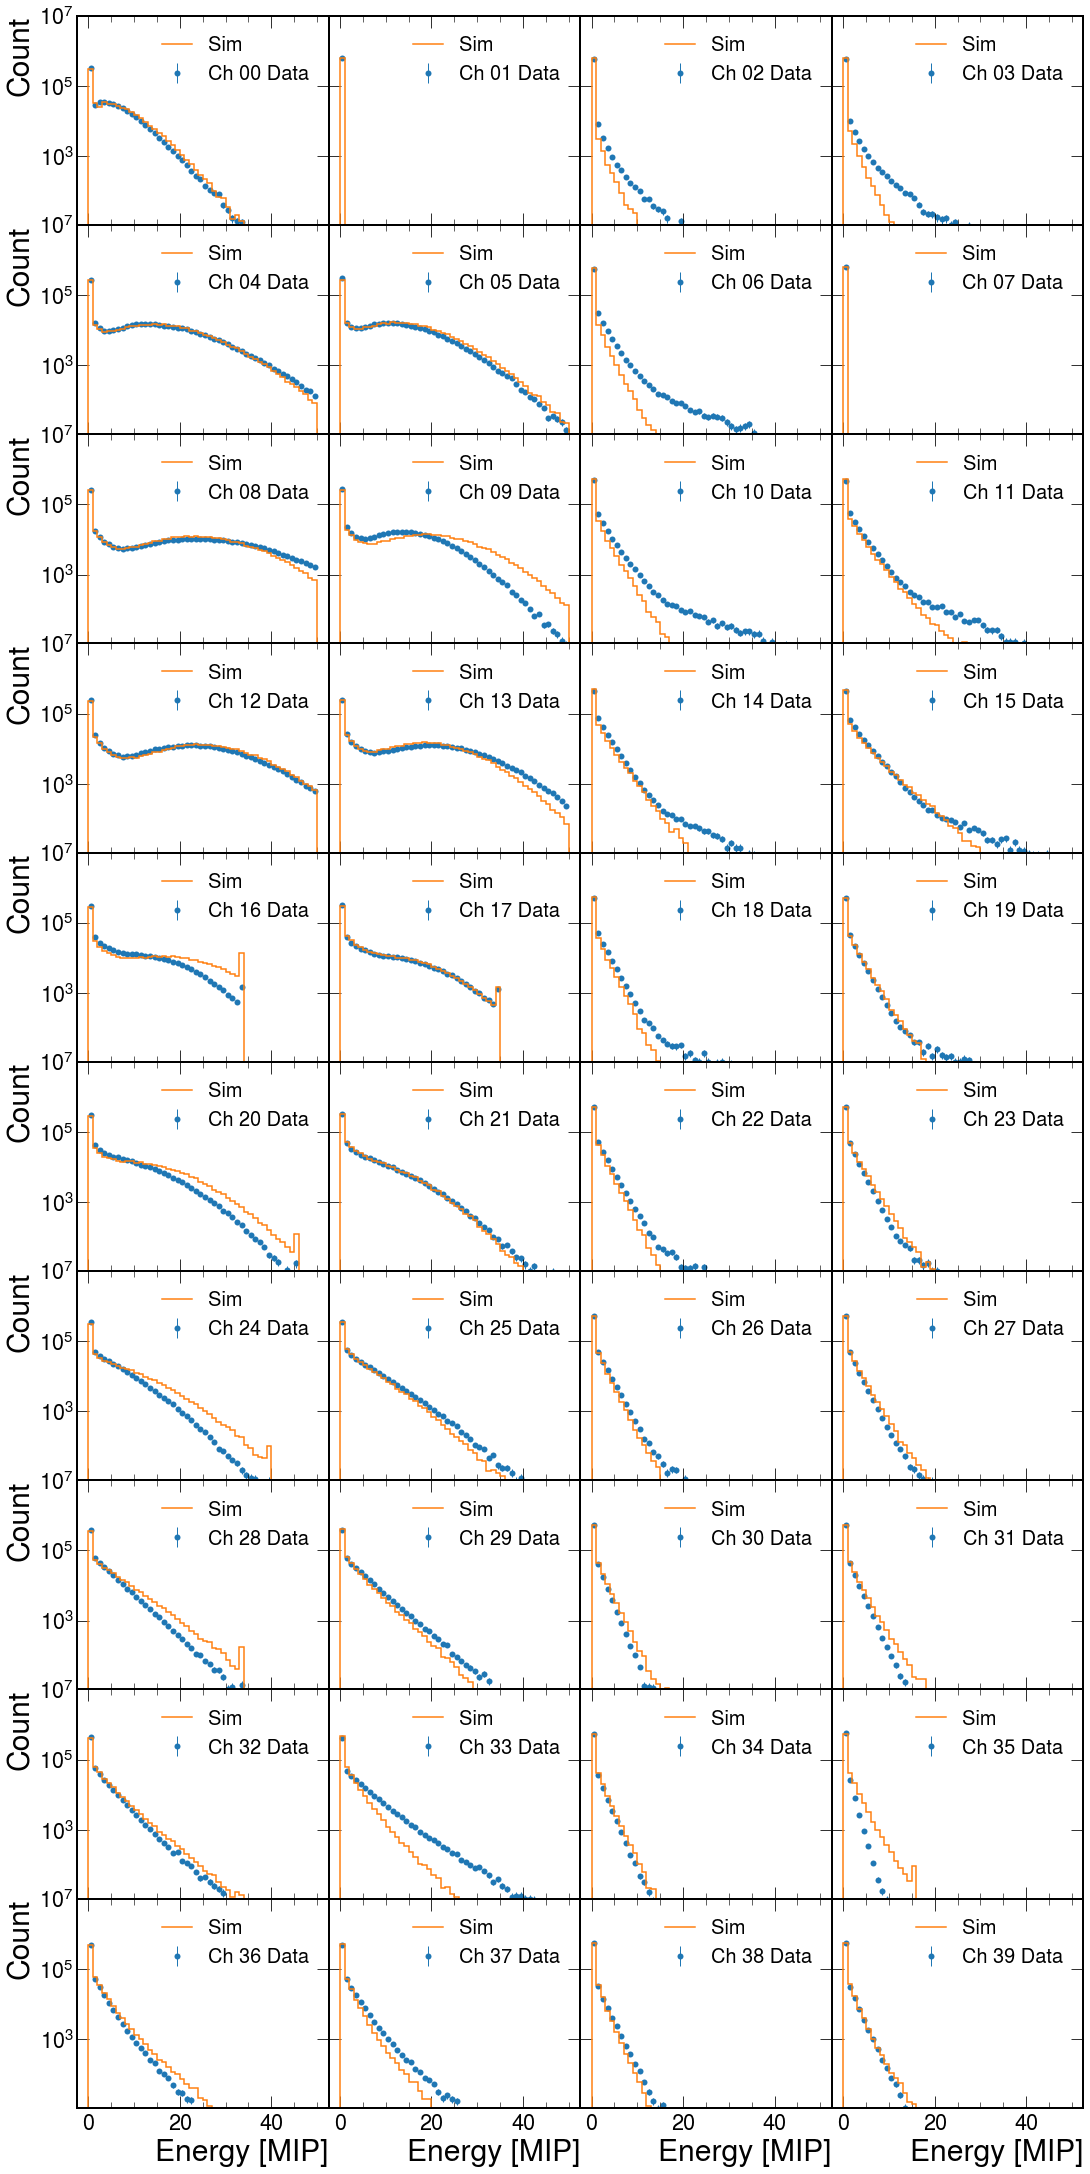

In [12]:
#Plot channel spectra for measurement data and simulation

fig, axs=plt.subplots(10, 4, figsize=(15,30),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
HGpedMeans = []
HGpedStds = []


for i in range(40):
    plt.sca(axs[i//4][i%4])
    
    h = hist.Hist(hist.axis.Regular(50, 0, 50, name="data"))
    h.fill(np.array(getattr(data_df,"Ch_{}_LG".format("{:02d}".format(i)))))
    h *= 1.0
    #h.plot(color='blue',label=f"Channel {i} Data")    
    
    # Calculate the square root of the histogram values (errors)
    errors = np.sqrt(h.view())
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    # Plot the histogram with error bars
    plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label="Ch {} Data".format("{:02d}".format(i)),zorder=1)
    
    h = hist.Hist(hist.axis.Regular(50, 0, 50, name="sim"))
    h.fill(np.array(getattr(sim_df,"Ch_{}_LG".format("{:02d}".format(i)))))
    h *= beamEvts/simEvts
    h.plot(color='tab:orange',label="Sim",zorder=2)    
    
    # Calculate the square root of the histogram values (errors)
    errors = np.sqrt(h.view())
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    # Plot the histogram with error bars
    #plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='none', ecolor='tab:orange', capsize=0, elinewidth=1, markeredgewidth=0,zorder=2)
   
    plt.yscale("log")
    #plt.ylim(ymin=1, ymax=10000000)

    plt.legend(loc='upper right', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if i>= 15:
        plt.xlabel('Energy [MIP]', fontsize=30)
    if i % 4 == 0 :
        plt.ylabel('Count', fontsize=30)
    plt.ylim(ymin=11, ymax=10000000)
    plt.yscale("log") 
    #plt.title("Channel {}".format("{:02d}".format(i)), y=0.8)

# Adjust the spacing between subplots
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)
plt.savefig('Plots/ChannelSpectra.pdf', format='pdf')

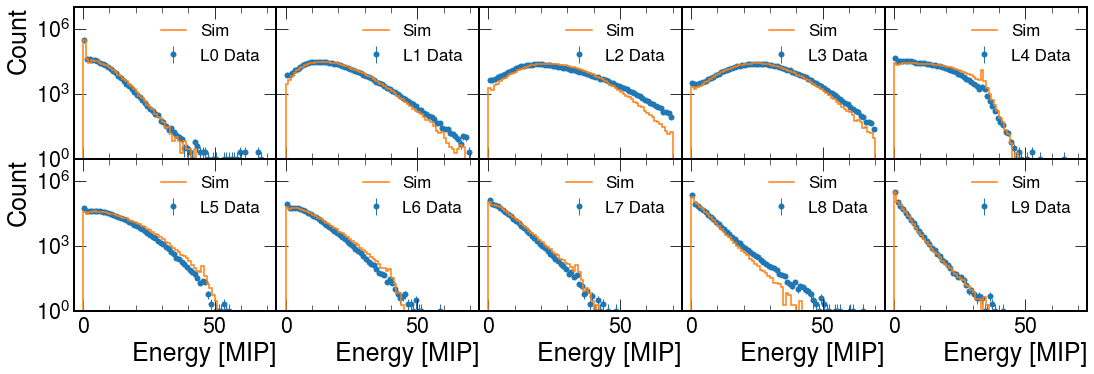

In [13]:
import hist

fig, axs=plt.subplots(2, 5, figsize=(15,5),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

DataMed = []
DataStd = []
SimMed = []
SimStd = []

channel = 0
for i in range(10):
    channel_numbers = [channel+0, channel+1, channel+2, channel+3] 
    channel = channel + 4
    if i <= 4:
        plt.sca(axs[0][i])
    else:
        plt.sca(axs[1][i-5])
        
    datCh = calculate_channel_sums(data_df, channel_numbers)

    DataMed.append(statistics.median(datCh))
    DataStd.append(statistics.pstdev(datCh))
    
    h = hist.Hist(hist.axis.Regular(70, 0, 70, name="data"))
    h.fill(datCh)
    h *= 1.0
    #h.plot(color='blue',label=f"Layer {i} Data")    
    
    
    # Calculate the square root of the histogram values (errors)
    errors = np.sqrt(h.view())
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    # Plot the histogram with error bars
    plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', color='tab:blue', ecolor='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0, label=f"L{i} Data",zorder=1)
    
    simCh = calculate_channel_sums(sim_df, channel_numbers)
    
    SimMed.append(statistics.median(simCh))
    SimStd.append(statistics.pstdev(simCh))

    h = hist.Hist(hist.axis.Regular(70, 0, 70, name="sim"))
    h.fill(simCh)
    h *= beamEvts/simEvts
    h.plot(color='tab:orange',label="Sim",zorder=2)
    
    #percent = (np.array(h) / np.array(h1)) * 100
    #print(max(percent)-100)
    #print(100 - min(percent))
    #print("next")
    
    # Calculate the square root of the histogram values (errors)
    errors = np.sqrt(h.view())
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    # Plot the histogram with error bars
    #plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='none', ecolor='red', capsize=0, elinewidth=1, markeredgewidth=0)

    plt.yscale("log") 
    if i >= 5:
        plt.xlabel('Energy [MIP]',fontsize=25)
    if i==0 or i == 5:
        plt.ylabel('Count',fontsize=25)
    
    plt.legend(loc='upper right',fontsize=17)
    plt.ylim(ymin=1, ymax=10000000)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0)

plt.savefig('Plots/LayerSums.pdf', format='pdf')

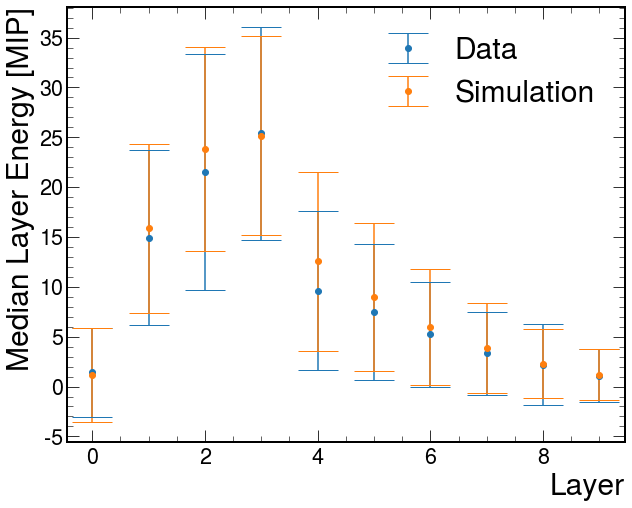

In [14]:
plt.errorbar(range(0,10), DataMed, yerr=DataStd, fmt="o", color='tab:blue', label='Data',capsize=20)
plt.errorbar(range(0,10), SimMed, yerr=SimStd, fmt="o", color='tab:orange', label='Simulation',capsize=20)

plt.xlabel('Layer',fontsize=30)
plt.ylabel('Median Layer Energy [MIP]',fontsize=30)
plt.legend(fontsize=30)
plt.savefig('Plots/LayerMeans.pdf', format='pdf')



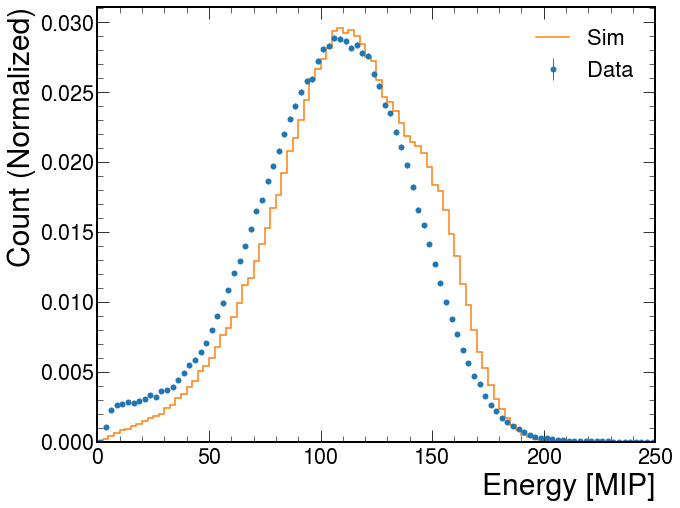

In [28]:
def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)
handles=[]

#plot calibrated total energy spectra, this is where we get our detector resolution

channel_numbers = np.array(range(40))

h = hist.Hist(hist.axis.Regular(100, 0, 250, name="data"))
ch_sum = calculate_channel_sums(data_df, channel_numbers)



h.fill(ch_sum)
errors = np.sqrt(h.view())
errors = errors/beamEvts
h = (h / beamEvts)

# Calculate the square root of the histogram values (errors)


# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

# Plot the histogram with error bars
plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0, label='Data')

minFit = np.mean(ch_sum) - 0.5*statistics.pstdev(ch_sum)
maxFit = np.mean(ch_sum) + 0.5*statistics.pstdev(ch_sum)
fitMask = (bin_centers > minFit) & (bin_centers < maxFit)
data = h.values()[fitMask]
bins = bin_centers[fitMask]

# Initial parameter values for the fit
initial_params = [0.03, 100, 50]
# Create Minuit object and set up the fit
m = Minuit(least_squares_loss, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
# Perform the fit
m.migrad()
# Get the fitted parameters
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(min(bins), max(bins), 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100*abs(sigma_fit)/mu_fit
fitMask = (x > minFit) & (x < maxFit)
#handles.append(plt.plot(x[fitMask], y_fit[fitMask], color='tab:blue', label='Data Fit\n$\mu$=%2.0f MIPs, \n$\sigma=$%2.0f MIPs'%(mu_fit,abs(sigma_fit)))[0])
plt.legend(fontsize=22,loc='upper right')
h = hist.Hist(hist.axis.Regular(100, 0, 250, name="sim"))
ch_sum = calculate_channel_sums(sim_df, channel_numbers)

h.fill(ch_sum)

errors = np.sqrt(h.view())
errors = errors/simEvts
h = (h / simEvts)
h.plot(color='tab:orange',label="Sim")
# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

# Plot the histogram with error bars
#plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='tab:orange', color='tab:orange', capsize=0, elinewidth=1, markeredgewidth=0,label="Sim")
#h.plot(color='tab:orange',label="Sim")
plt.legend(fontsize=22,loc='upper right')

# Calculate the square root of the histogram values (errors)
errors = np.sqrt(h.view())
# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
# Plot the histogram with error bars
#plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='none', ecolor='red', capsize=0, elinewidth=1, markeredgewidth=0)

minFit = np.mean(ch_sum) - 0.5*statistics.pstdev(ch_sum)
maxFit = np.mean(ch_sum) + 0.5*statistics.pstdev(ch_sum)
fitMask = (bin_centers > minFit) & (bin_centers < maxFit)
data = h.values()[fitMask]
bins = bin_centers[fitMask]

# Initial parameter values for the fit
initial_params = [0.03, 100, 50]
# Create Minuit object and set up the fit
m = Minuit(least_squares_loss, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
# Perform the fit
m.migrad()
# Get the fitted parameters
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(min(bins), max(bins), 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100*abs(sigma_fit)/mu_fit
fitMask = (x > minFit) & (x < maxFit)
#plt.plot(x[fitMask], y_fit[fitMask], 'tab:orange', label='Sim Fit \n$\mu$=%2.0f MIPs, \n$\sigma=$%2.0f MIPs'%(mu_fit,abs(sigma_fit)),zorder=3)
plt.xlim(0,250)
plt.xlabel('Energy [MIP]', fontsize=30)
plt.ylabel('Count (Normalized)', fontsize=30)
plt.legend(fontsize=22,loc='upper right')
plt.savefig('Plots/TotEnergy.pdf', format='pdf')

[14719. 15259. 16299. 16926. 17997. 18555. 18472. 17367. 15682. 13176.
 10344.  7778.  5376.  3384.  2180.  1276.   677.   385.   220.   128.]
[ 77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5 117.5 122.5 127.5 132.5
 137.5 142.5 147.5 152.5 157.5 162.5 167.5 172.5]


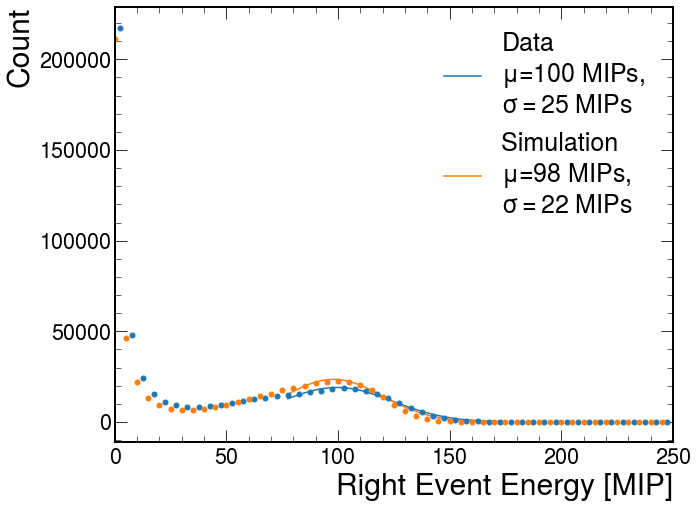

In [16]:
#plot calibrated total energy spectra, this is where we get our detector resolution

channel_numbers = np.array(range(40))
channel_numbers = channel_numbers[channel_numbers%2 == 1]

h = hist.Hist(hist.axis.Regular(50, 0, 250, name="data"))
h.fill(calculate_channel_sums(data_df, channel_numbers))
h = h*1
#h.plot(color='blue')

# Calculate the square root of the histogram values (errors)
errors = np.sqrt(h.view())

# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

# Plot the histogram with error bars
plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

#data = h.values()[()]
#bins = h.axes[0].edges[:-1]

data = h.values()[15:-15]
bins = bin_centers[15:-15]
print(data)
print(bins)

# Initial parameter values for the fit
initial_params = [3000, 100, 50]
# Create Minuit object and set up the fit
m = Minuit(least_squares_loss, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
# Perform the fit
m.migrad()
# Get the fitted parameters
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(min(bins), max(bins), 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100*abs(sigma_fit)/mu_fit
plt.plot(x, y_fit, color='tab:blue', label='Data\n$\mu$=%2.0f MIPs, \n$\sigma=$%2.0f MIPs'%(mu_fit,abs(sigma_fit)))

h = hist.Hist(hist.axis.Regular(50, 0, 250, name="sim"))
h.fill(calculate_channel_sums(sim_df, channel_numbers))
h = (h / simEvts) * beamEvts
#h.plot(color='tab:orange')
# Create a numpy array for the bin centers
bin_centers = h.axes[0].edges[:-1]

# Plot the histogram with error bars
plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='tab:orange', color='tab:orange', capsize=0, elinewidth=1, markeredgewidth=0)


# Calculate the square root of the histogram values (errors)
errors = np.sqrt(h.view())
# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
# Plot the histogram with error bars
#plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='none', ecolor='red', capsize=0, elinewidth=1, markeredgewidth=0)


#data = h.values()[()]
#bins = h.axes[0].edges[:-1]
data = h.values()[15:-15]
bins = bin_centers[15:-15]

# Initial parameter values for the fit
initial_params = [3000, 100, 50]
# Create Minuit object and set up the fit
m = Minuit(least_squares_loss, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
# Perform the fit
m.migrad()
# Get the fitted parameters
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(min(bins), max(bins), 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100*abs(sigma_fit)/mu_fit
plt.plot(x, y_fit, 'tab:orange', label='Simulation \n$\mu$=%2.0f MIPs, \n$\sigma=$%2.0f MIPs'%(mu_fit,abs(sigma_fit)))
plt.xlim(0,250)
plt.xlabel('Right Event Energy [MIP]', fontsize=30)
plt.ylabel('Count', fontsize=30)
plt.legend(fontsize=25,loc='upper right')


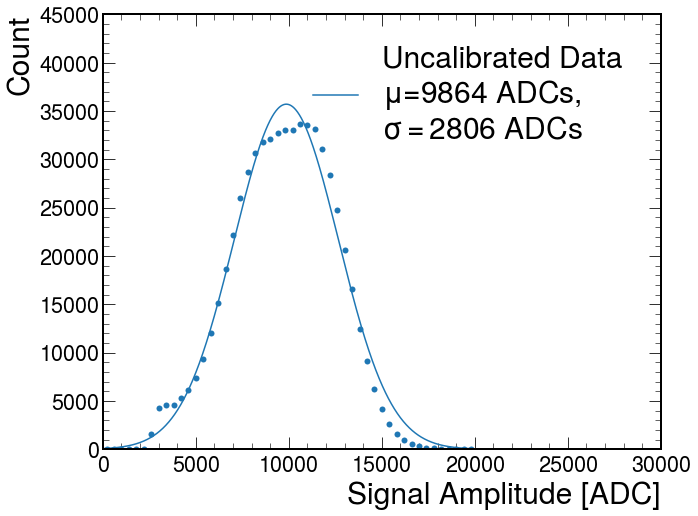

In [17]:
#plot calibrated total energy spectra, this is where we get our detector resolution

channel_numbers = np.array(range(40))

df_LG = only_lowgain(df)


h = hist.Hist(hist.axis.Regular(50, 0, 20000, name="data"))
h.fill(calculate_channel_sums(df_LG, channel_numbers))
h = h*1
#h.plot(color='blue')


# Calculate the square root of the histogram values (errors)
errors = np.sqrt(h.view())
# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
# Plot the histogram with error bars
plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)


data = h.values()[()]
bins = bin_centers

# Initial parameter values for the fit
initial_params = [3000, 18000, 500]
# Create Minuit object and set up the fit
m = Minuit(least_squares_loss, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
# Perform the fit
m.migrad()
# Get the fitted parameters
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
x = np.linspace(0, 20000, 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100*abs(sigma_fit)/mu_fit
plt.plot(x, y_fit, 'tab:blue', label='Uncalibrated Data \n$\mu$=%2.0f ADCs, \n$\sigma=$%2.0f ADCs'%(mu_fit,abs(sigma_fit)))
plt.xlim(0,30000)
plt.ylim(0,45000)
plt.xlabel('Signal Amplitude [ADC]', fontsize=30)
plt.ylabel('Count', fontsize=30)
plt.legend(fontsize=30,loc='upper right')

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide


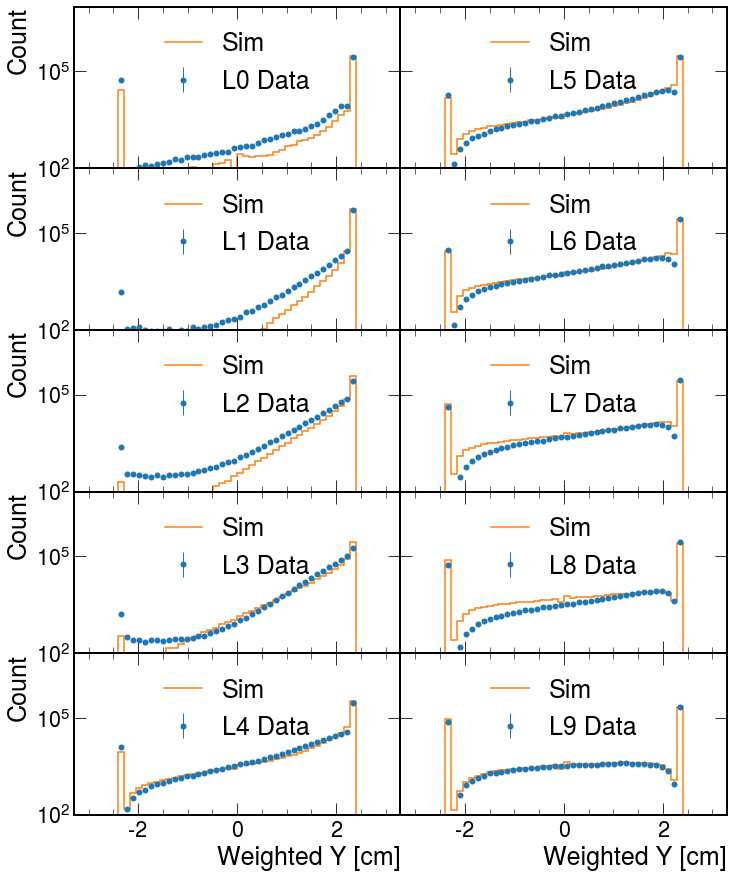

In [18]:
# Create a figure with subplots
fig, axs=plt.subplots(5, 2, figsize=(10,12),sharey=True,sharex=True)
layer_y_positions = get_layer_positions(data_df, 'y')
simlayer_y_positions = get_layer_positions(sim_df, 'y')

MeanYPos = []
SimMeanYPos = []

# Iterate over the column indices (layers)
for i in range(10):

    # Select the appropriate subplot based on the layer index
    if(i < 5):
        plt.sca(axs[i][0])
    if(i >= 5):
        plt.sca(axs[i-5][1])  


    # Plot the histogram of the x positions
    h = hist.Hist(hist.axis.Regular(50, -3.0, 3.0, name="data"))
    h.fill(layer_y_positions[i])
    h=h*1
    #h.plot(label=f'L{i} Data $\mu$= %2.1f cm'%(np.nanmean(layer_y_positions[i])),color='blue')
    
    # Calculate the square root of the histogram values (errors)
    errors = np.sqrt(h.view())
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    # Plot the histogram with error bars
    plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0, label=f'L{i} Data')

    MeanYPos.append(np.nanmean(layer_y_positions[i]))

    h = hist.Hist(hist.axis.Regular(50, -3.0, 3.0, name="Sim"))
    h.fill(simlayer_y_positions[i])
    h = (h / simEvts) * beamEvts
    h.plot(label='Sim',color='tab:orange')
    
    # Calculate the square root of the histogram values (errors)
    errors = np.sqrt(h.view())
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    # Plot the histogram with error bars
    #plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='red', capsize=0, elinewidth=1, markeredgewidth=0)
    
    SimMeanYPos.append(np.nanmean(simlayer_y_positions[i]))
    
   # Set the title and axis labels for the subplot   
    if i == 4 or i == 9:
        plt.xlabel('Weighted Y [cm]', fontsize=25)
    if i <= 4:
        plt.ylabel('Count', fontsize=25)
    plt.legend(loc='upper center', fontsize=25)
    plt.yscale("log") 
    plt.ylim(ymin=100, ymax=10000000)

# Adjust the spacing between subplots
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0)
plt.subplots_adjust(wspace=0.0)

plt.savefig('Plots/Y-Distributions.pdf', format='pdf')

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide


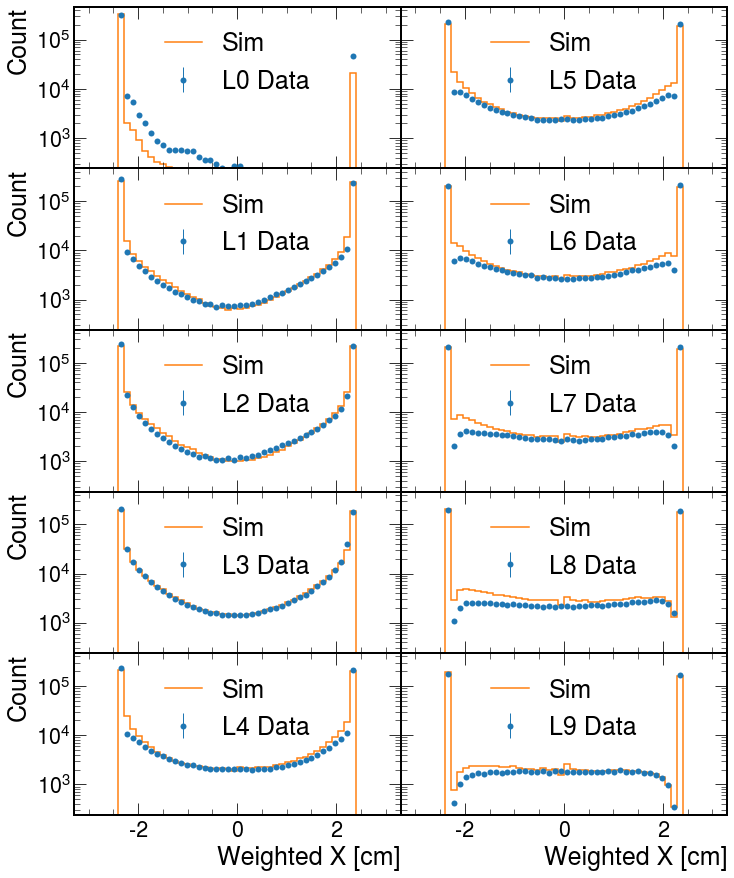

In [19]:
# Create a figure with subplots
fig, axs=plt.subplots(5, 2, figsize=(10,12),sharey=True,sharex=True)
layer_x_positions = get_layer_positions(data_df, 'x')
simlayer_x_positions = get_layer_positions(sim_df, 'x')
MeanXPos = []
SimMeanXPos = []

# Iterate over the column indices (layers)
for i in range(10):

    # Select the appropriate subplot based on the layer index
    if(i < 5):
        plt.sca(axs[i][0])
    if(i >= 5):
        plt.sca(axs[i-5][1])  

    # Plot the histogram of the x positions
    
    h = hist.Hist(hist.axis.Regular(50, -3.0, 3.0, name=" "))
    h.fill(layer_x_positions[i])
    h=h*1
    #h.plot(label=f'L{i} Data $\mu$= %2.1f cm'%(np.nanmean(layer_x_positions[i])),color='blue')
    # Calculate the square root of the histogram values (errors)
    errors = np.sqrt(h.view())
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    # Plot the histogram with error bars
    plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f'L{i} Data')
    
    MeanXPos.append(np.nanmean(layer_x_positions[i]))

    h = hist.Hist(hist.axis.Regular(50, -3.0, 3.0, name="sim"))
    h.fill(simlayer_x_positions[i])
    h = (h / simEvts) * beamEvts
    h.plot(label='Sim',color='tab:orange')
    
    # Calculate the square root of the histogram values (errors)
    errors = np.sqrt(h.view())
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    # Plot the histogram with error bars
    #plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o', ecolor='red', color='red', capsize=0, elinewidth=1, markeredgewidth=0)

    
    
    SimMeanXPos.append(np.nanmean(simlayer_x_positions[i]))
    
    # Set the title and axis labels for the subplot   
    if i == 4 or i == 9:
        plt.xlabel('Weighted X [cm]', fontsize=25)
    if i <= 4:
        plt.ylabel('Count', fontsize=25)
    plt.legend(loc='upper center', fontsize=25)
    plt.yscale("log") 
    

# Adjust the spacing between subplots
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0)
plt.savefig('Plots/X-Distributions.pdf', format='pdf')

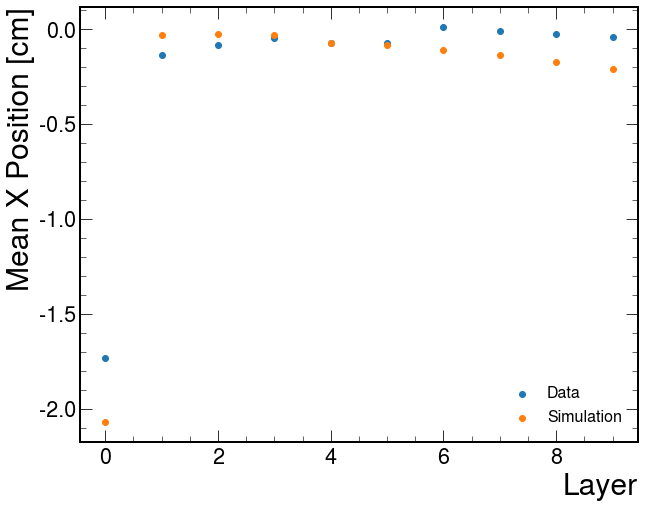

In [20]:
#Plot layer vs mean x position

plt.scatter(range(0,10), y=MeanXPos, label='Data')
plt.scatter(range(0,10), y=SimMeanXPos, color='tab:orange', label='Simulation')
plt.xlabel('Layer', fontsize=30)
plt.ylabel('Mean X Position [cm]', fontsize=30)
plt.legend()
#plt.title('Layer vs Mean X Position')

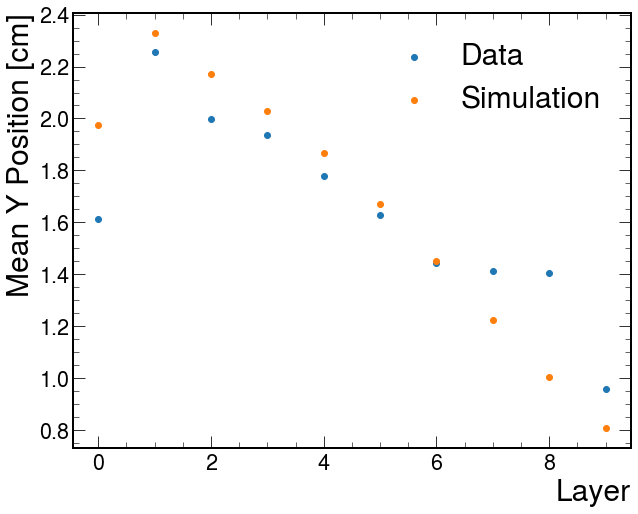

In [21]:
#Plot layer vs mean y position

plt.scatter(range(0,10), y=MeanYPos, label='Data')
plt.scatter(range(0,10), y=SimMeanYPos, color='tab:orange', label='Simulation')
plt.xlabel('Layer', fontsize=30)
plt.ylabel('Mean Y Position [cm]', fontsize=30)
plt.legend(fontsize=30)

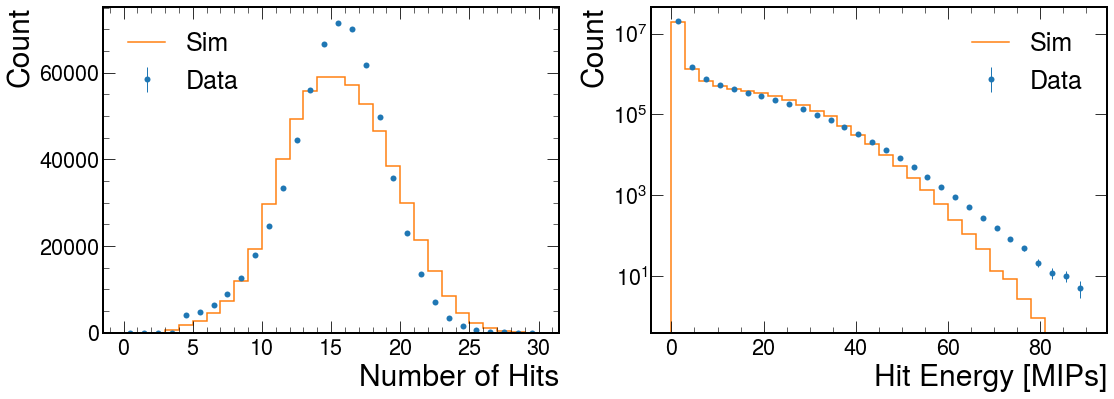

In [22]:
fig, axs=plt.subplots(1, 2, figsize=(18,6))
plt.sca(axs[0])

#Plot the number of significant hits per event

data_counts = np.count_nonzero(data_df.values, axis=1)

sim_counts = np.count_nonzero(sim_df.values, axis=1)

h = hist.Hist(hist.axis.Regular(30, 0, 30, name="data"))
h.fill(data_counts)
h=h*1
#h.plot(label='Data $\mu$= %2.2f' % np.mean(data_counts),color='blue')

# Calculate the square root of the histogram values (errors)
errors = np.sqrt(h.view())

# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

# Plot the histogram with error bars
plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o',color='tab:blue', ecolor='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label='Data')

h = hist.Hist(hist.axis.Regular(30, 0, 30, name="sim"))
h.fill(sim_counts)
# Renormalization step
h = (h / simEvts) * beamEvts
h.plot(label='Sim',color='tab:orange')


# Calculate the square root of the histogram values (errors)
errors = np.sqrt(h.view())

# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

# Plot the histogram with error bars
#plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='none', ecolor='red', capsize=0, elinewidth=1, markeredgewidth=0)


plt.xlabel('Number of Hits', fontsize=30)
plt.ylabel('Count', fontsize=30)
plt.legend(loc='upper left', fontsize=25)

plt.sca(axs[1])
#Plot the number of significant hits per event

data_counts = np.count_nonzero(data_df.values, axis=1)

sim_counts = np.count_nonzero(sim_df.values, axis=1)

h = hist.Hist(hist.axis.Regular(30, 0, 90, name="data"))
h.fill(ak.flatten(data_df.values))
h=h*1
#h.plot(label='Data $\mu$= %2.2f' % np.mean(data_counts),color='blue')

# Calculate the square root of the histogram values (errors)
errors = np.sqrt(h.view())

# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

# Plot the histogram with error bars
plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o',color='tab:blue', ecolor='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label='Data')

h = hist.Hist(hist.axis.Regular(30, 0, 90, name="sim"))
h.fill(ak.flatten(sim_df.values))
# Renormalization step
h = (h / simEvts) * beamEvts
h.plot(label='Sim',color='tab:orange')


# Calculate the square root of the histogram values (errors)
errors = np.sqrt(h.view())

# Create a numpy array for the bin centers
bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

# Plot the histogram with error bars
#plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='none', ecolor='red', capsize=0, elinewidth=1, markeredgewidth=0)
plt.yscale("log") 

plt.xlabel('Hit Energy [MIPs]', fontsize=30)
plt.ylabel('Count', fontsize=30)
plt.legend(loc='upper right', fontsize=25)


plt.savefig('Plots/Hit-Counts-Energy.pdf', format='pdf')

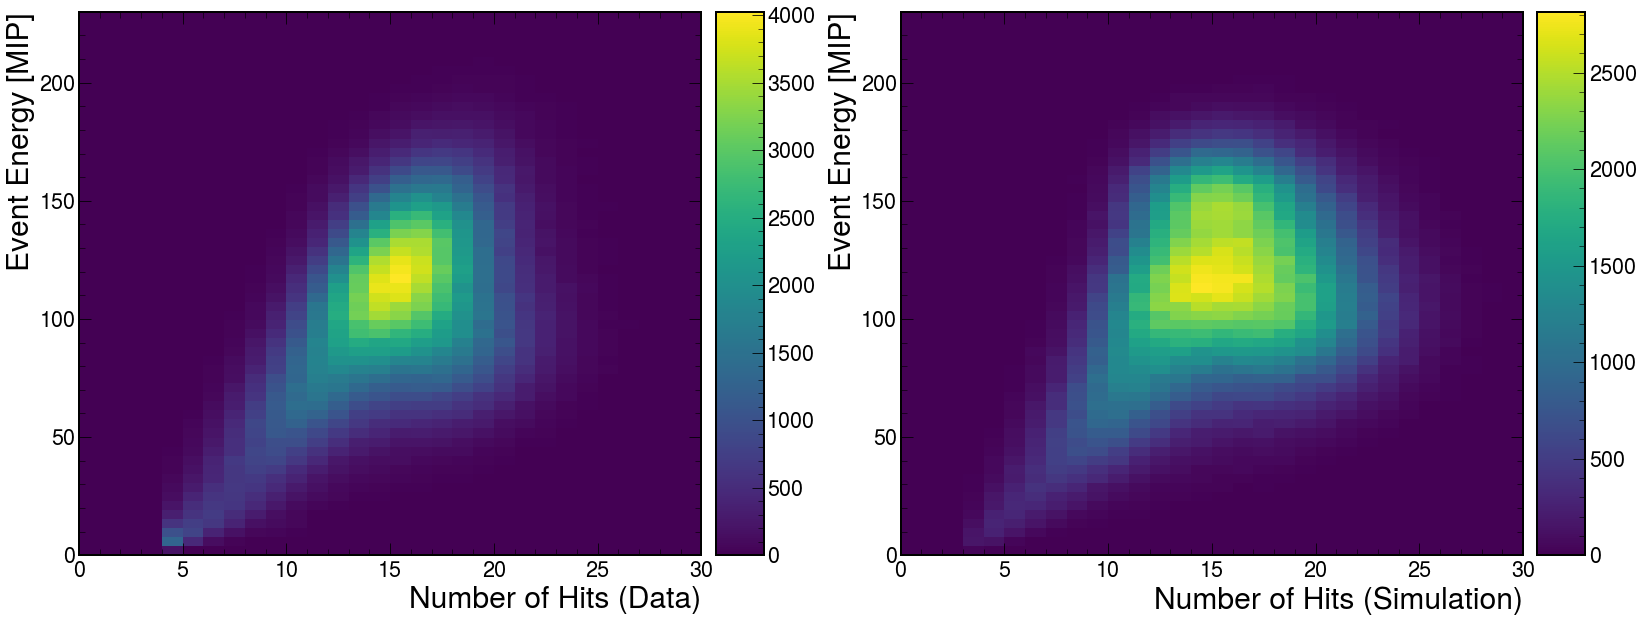

In [23]:
fig, axs=plt.subplots(1, 2, figsize=(27,10))
plt.sca(axs[0])
h = Hist(
    hist.axis.Regular(30, 0, 30, name="S", label="Number of Hits (Data)", flow=False),
    hist.axis.Regular(60, 0, 230, name="W", label="Energy [MIP]", flow=False),
)

channel_numbers = np.array(range(40))
plt.xlabel('Number of Hits (Data)', fontsize=30)
plt.ylabel('Event Energy [MIP]', fontsize=30)

h.fill(data_counts, calculate_channel_sums(data_df, channel_numbers))
h.plot()

plt.sca(axs[1])
h = Hist(
    hist.axis.Regular(30, 0, 30, name="S", label="Number of Hits (Simulation)", flow=False),
    hist.axis.Regular(60, 0, 230, name="W", label="Energy [MIP]", flow=False),
)

channel_numbers = np.array(range(40))
plt.xlabel('Number of Hits (Simulation)', fontsize=30)
plt.ylabel('Event Energy [MIP]', fontsize=30)

h.fill(sim_counts, calculate_channel_sums(sim_df, channel_numbers))
# Renormalization step
h = (h / simEvts) * beamEvts
h.plot()
plt.savefig('Plots/Hits-vs-Energy.pdf', format='pdf')

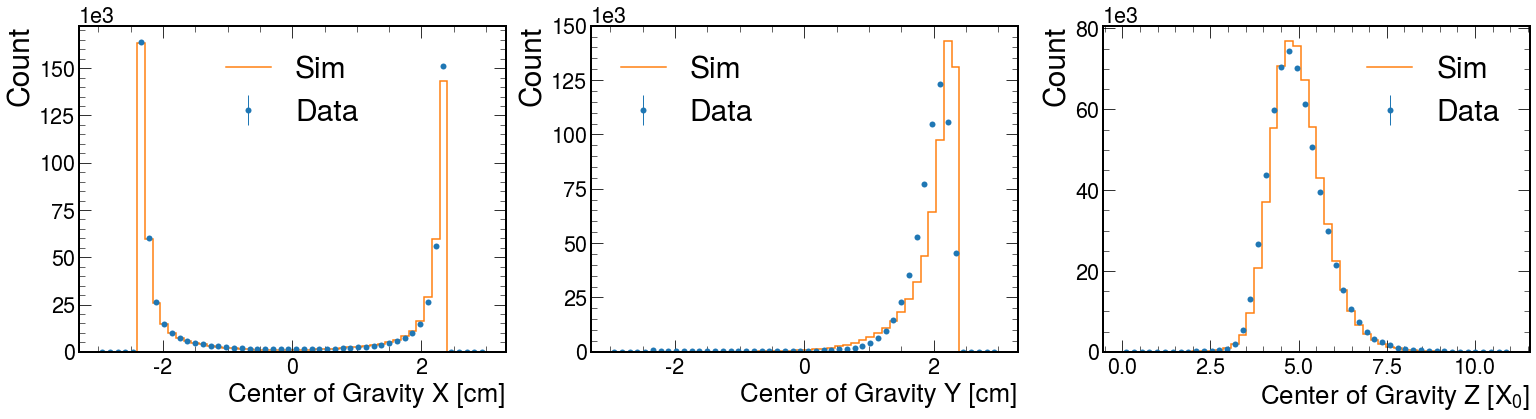

In [24]:
def get_COG(in_df, coor='x'):
    if coor not in ['x', 'y', 'z']:
        print(f'ERROR:\tinvalid coordinate: {corr}. Valid value: x, y')
        return
    pos = {}
    pos['x'] = np.array([-1, 1, -1, 1]*10)
    pos['y'] = np.array([1, 1, -1, -1]*10)
    pos['z'] = np.array([ [i] * 4 for i in range(1, 11) ]).flatten() 
    value = {}
    value['x'] = 4.74/2
    value['y'] = 4.74/2
    value['z'] = 1.167  # radiation length
    
    channels = np.array(in_df.iloc[:, :40])
    event_energy = np.sum(channels, axis=1)
    weighted_coor = channels*pos[coor]
    return np.sum(weighted_coor, axis=1)/event_energy*value[coor]


# plot COG
xmin = {'x': -3, 'y': -3, 'z': 0}
xmax = {'x': 3, 'y': 3, 'z': 11}
fig, axs = plt.subplots(1, 3, figsize=(26, 6))
xtitle = {'x': 'Center of Gravity X [cm]', 'y': 'Center of Gravity Y [cm]', 'z': 'Center of Gravity Z [$X_0$]'}
i=0
for coor in ['x', 'y', 'z']:
    plt.sca(axs[i])
    i = i+1
    data = get_COG(data_df, coor)
    sim = get_COG(sim_df, coor)
    
    h = hist.Hist(hist.axis.Regular(50, xmin[coor], xmax[coor], name="data"))
    h.fill(data)
    h=h*1
    
    # Calculate the square root of the histogram values (errors)
    errors = np.sqrt(h.view())
    
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

    # Plot the histogram with error bars
    plt.errorbar(bin_centers, h.view(), yerr=errors, fmt='o',color='tab:blue', ecolor='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label='Data')
    
    h = hist.Hist(hist.axis.Regular(50, xmin[coor], xmax[coor], name="sim"))
    h.fill(sim)
    # Renormalization step
    h = (h / simEvts) * beamEvts
    h.plot(label='Sim',color='tab:orange')
    
    plt.xlabel(xtitle[coor])
    plt.ylabel('Count', fontsize=30)
    plt.legend(fontsize=30)
    if coor=='x':
        plt.legend(fontsize=30, loc='upper center')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(3,3))

    
plt.savefig(f'Plots/COG.pdf')
    
    

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7fc421951dd0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7fc33df20d50>, text=[])

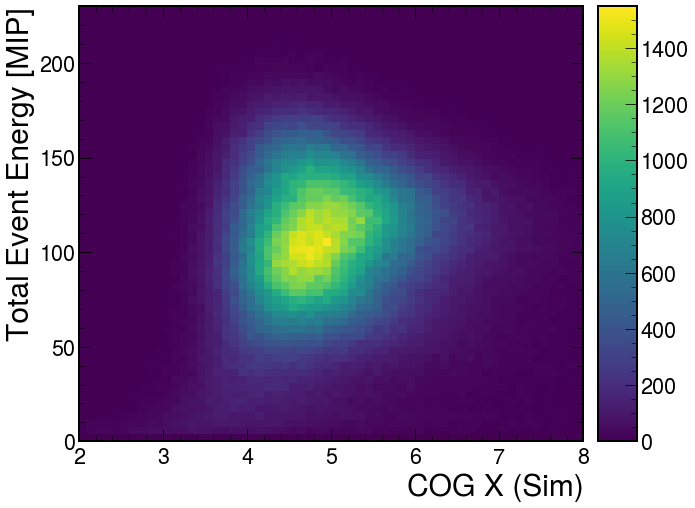

In [25]:
coor = 'z'

h = Hist(
    hist.axis.Regular(60, 2.0, 8.0, name="S", label="COG X (Data)", flow=False),
    hist.axis.Regular(60, 0, 230, name="W", label="Total Event Energy [MIP]", flow=False),
)

channel_numbers = np.array(range(40))
plt.xlabel('COG X (Sim)', fontsize=30)
plt.ylabel('Total Event Energy [MIP]', fontsize=30)

h.fill(get_COG(data_df, coor), calculate_channel_sums(data_df, channel_numbers))
h.plot()